# Hierarchical Clustering with MPDist

In this tutorial you will see how to use the novel MPDist metric to cluster time series data. The time series data used in this example is accelerometer data consisting of individuals performing the following actions:

1. Working at Computer
2. Standing Up, Walking and Going updown stairs
3. Standing
4. Walking
5. Going UpDown Stairs
6. Walking and Talking with Someone
7. Talking while Standing

You can read more about the data set here:

http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer

In essence, MPDist considers "...two time series to be similar if they share many similar subsequences, regardless of the order of matching
subsequences." [1] I encourage those interested in the details of the metric to read the paper.

**Note that all code written in this tutorial has only been tested with Python 3!**

In [1]:
import pandas as pd
import numpy as np
import matrixprofile as mp
from scipy.cluster.hierarchy import dendrogram

from matplotlib import pyplot as plt

%matplotlib inline

## Download and Extract Data

In this section we simply obtain the dataset and extract it.

In [2]:
import urllib.request
import zipfile
import tempfile
import os

In [3]:
temp_dir = tempfile.mkdtemp()
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip'
tmp_file = os.path.join(temp_dir, 'activity_recognition.zip')
extracted_dir = os.path.join(temp_dir, 'extracted')

os.makedirs(extracted_dir, exist_ok=True)

with urllib.request.urlopen(url) as response, open(tmp_file, 'wb') as out_file:
    data = response.read() # a `bytes` object
    out_file.write(data)
    
with zipfile.ZipFile(tmp_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
    
data_dir = os.path.join(extracted_dir, 'Activity Recognition from Single Chest-Mounted Accelerometer')

## Load Raw Data

In this section we load the raw data and process it. For readability purposes, the target labels are transformed into human readable descriptions.

In [4]:
label_description = '''
1: Working at Computer
2: Standing Up, Walking and Going updown stairs
3: Standing
4: Walking
5: Going UpDown Stairs
6: Walking and Talking with Someone
7: Talking while Standing
'''

labels = []

for line in label_description.split('\n'):
    line = line.strip()
    if line == '':
        continue
    
    tmp = line.split(':')
    num = tmp[0].strip()
    description = tmp[1].strip()
    
    labels.append({
        'label': str(num),
        'description': description
    })

labels_df = pd.DataFrame(labels)

In [5]:
labels_df

,label,description
0,1,Working at Computer
1,2,"Standing Up, Walking and Going updown stairs"
2,3,Standing
3,4,Walking
4,5,Going UpDown Stairs
5,6,Walking and Talking with Someone
6,7,Talking while Standing


This code snippet reads all of the csv files with pandas and combines them into a single data frame.

In [6]:
from glob import glob

dfs = []

for csv in glob(os.path.join(data_dir, '*.csv')):
    df = pd.read_csv(csv, header=None, names=['sequence', 'x', 'y', 'z', 'label'])
    df['label'] = df['label'].astype('str')
    df['participant_id'] = csv.split('/')[-1].replace('.csv', '')
    df = pd.merge(df, labels_df, on='label')
    dfs.append(df)

df = pd.concat(dfs)

In [7]:
df

,sequence,x,y,z,label,participant_id,description
0,0.0,1983,2438,1825,1,11,Working at Computer
1,1.0,1948,2442,1797,1,11,Working at Computer
2,2.0,1927,2388,1784,1,11,Working at Computer
3,3.0,1960,2319,1831,1,11,Working at Computer
4,4.0,1967,2274,1871,1,11,Working at Computer
...,...,...,...,...,...,...,...
122195,122200.0,2063,2360,2000,7,4,Talking while Standing
122196,122200.0,2056,2368,2001,7,4,Talking while Standing
122197,122200.0,2059,2366,2001,7,4,Talking while Standing
122198,122200.0,2063,2382,2004,7,4,Talking while Standing


The data consists of multiple coordinates from the accelerometer readings. Here we will just use the x data point.

In [8]:
cols = ['sequence', 'x', 'label', 'participant_id', 'description']

df = df[cols].copy()

## Visualize Participant Data

Here we just plot the entire x signal for a few participants to get an understanding of what the data looks like. 

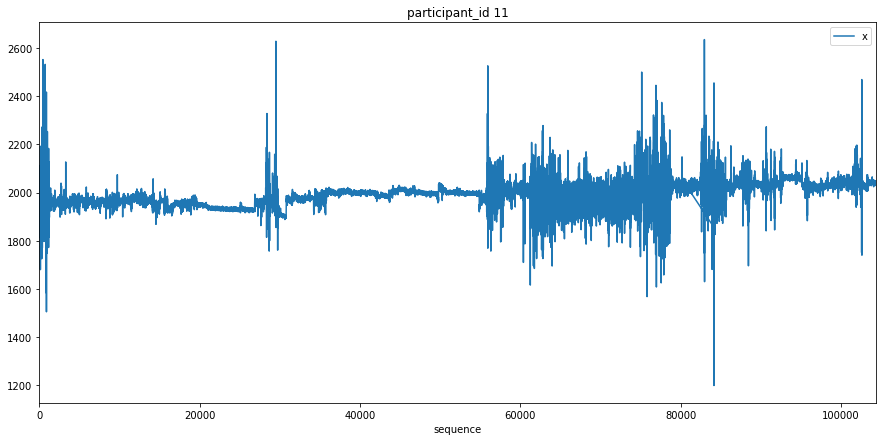

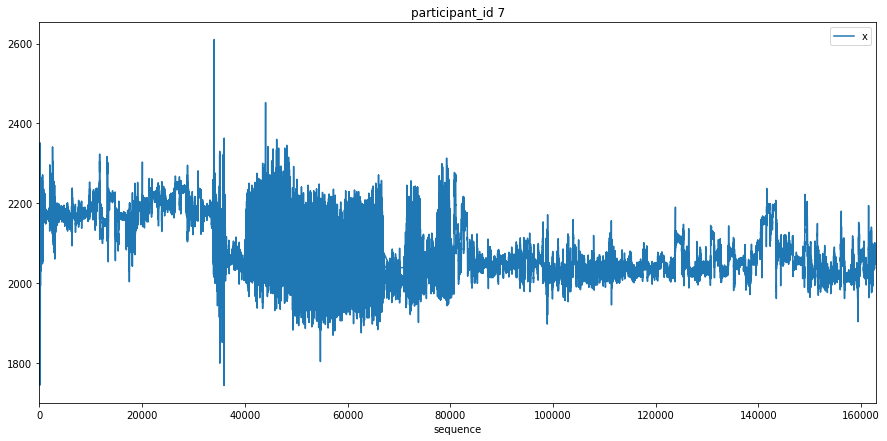

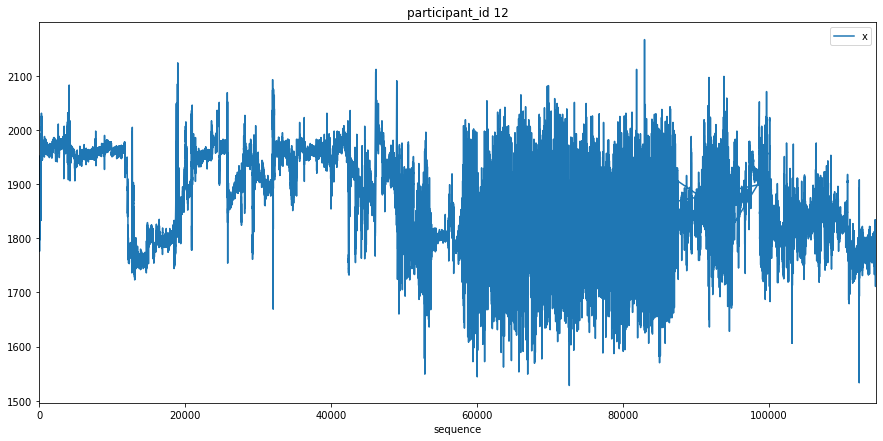

In [9]:
c = 0
for participant_id in df['participant_id'].unique():
    c += 1
    df[df['participant_id'] == participant_id].plot(x='sequence', y='x', title=f'participant_id {participant_id}', figsize=(15, 7))
    plt.show()
    
    if c >= 3:
        break

## Transform Data

This section transforms the data so that we have subsequences of data corresponding to a given activity. The series_data array contains the subsequences of an activity, the series labels are used to keep track of the activity, and the participant labels are used to keep track of the participant.

In [10]:
df = df.sort_values(['participant_id', 'sequence'])

In [11]:
series_data = []
series_labels = []
participant_labels = []

for idx, items in labels_df.iterrows():
    descr = items['description']
    label = items['label']
    
    for participant_id in df['participant_id'].unique():
        mask = (df['participant_id'] == participant_id) & (df['label'] == label)
        values = df[mask]['x'].values
        
        series_data.append(values)
        series_labels.append(descr)
        participant_labels.append(participant_id)

In [12]:
len(series_data[0]), series_labels[0], participant_labels[0]

(33677, 'Working at Computer', '1')

## Random Sampling

Here we take 25 random samples from the data set to see if our clustering seems logical. This saves time in the exploration phase allowing you to test more parameters.

In [13]:
np.random.seed(9999)
random_indices = np.random.choice(np.arange(105), size=25, replace=False)

In [14]:
random_samples = []
random_labels = []

for random_index in random_indices:
    random_samples.append(series_data[random_index])
    random_labels.append(series_labels[random_index])

## Good Enough Window Size

Here we look identify what a "good" window size may be based on the minimum length of the time series. The window size must be smaller than the smallest time series length for the MPDist calculation to work.

In [15]:
lengths = []

for ts in random_samples:
    lengths.append(len(ts))

np.min(lengths)

928

## Clustering and Visualizing Results

Now that all of the data processing is complete, we can finally cluster the sampled data and look at the results.

In [16]:
clusters = mp.discover.hierarchical_clusters(random_samples, 128, 2, n_jobs=8)

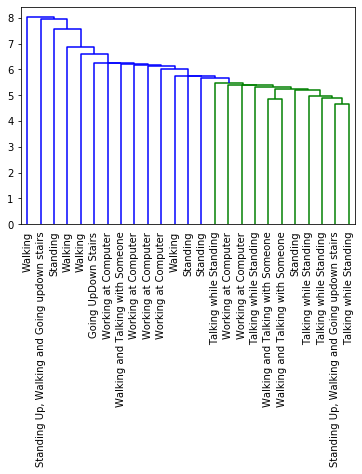

In [17]:
dendrogram(clusters['linkage_matrix'], labels=random_labels, leaf_rotation=90)
plt.show()

The results seem logical, however the dataset used uncalibrated accelerometers and I only chose to use the x value. I do not know if the x value is representative enough to identify all activities. With this in mind, I encourage you to take this example and test it on the z or y value and even toy with the clustering parameters.

## Citations

1. Matrix Proﬁle XII: MPdist: A Novel Time Series Distance Measure to Allow Data Mining in More Challenging Scenarios. Shaghayegh Gharghabi, Shima Imani, Anthony Bagnall, Amirali Darvishzadeh, Eamonn Keogh. ICDM 2018. [expanded version PDF](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxtcGRpc3RpbmZvfGd4OjNjMGZjOTBmYWEzNjM0ZWY)